In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
SEED = 2016

In [2]:
# Get data
train = pd.read_csv("raw_data/input_train.csv", sep = ";")
test = pd.read_csv("raw_data/input_test.csv", sep = ";")
y = pd.read_csv("raw_data/output_train.csv", sep = ";")
print("train : " + str(train.shape))
print("test : " + str(test.shape))
print("y : " + str(y.shape))

test_ids = test.Id

train : (11708, 8)
test : (2429, 8)
y : (11708, 6)


In [4]:
print("Training set")
display(train.head(3))
display(train.tail(3))
print("-----")
print("Test set")
display(test.head(3))
display(test.tail(3))
print("-----")
display(y.head(3))
display(y.tail(3))

print("Seems we have 4 months of training data, and we must predict the 5th month")

Training set


,Id,Id_bat,Time,x1,x2,x3,x4,x5
0,0,1,2016-01-01 00:00:00,1.500,8.100,22.000,380.183,20.000
1,1,1,2016-01-01 01:00:00,1.600,8.200,21.900,378.100,120.000
2,2,1,2016-01-01 02:00:00,1.400,7.900,21.900,374.983,120.000


,Id,Id_bat,Time,x1,x2,x3,x4,x5
11705,11705,4,2016-05-01 21:00:00,0.100,13.200,22.000,564.533,20.000
11706,11706,4,2016-05-01 22:00:00,0.600,12.500,21.900,572.900,20.000
11707,11707,4,2016-05-01 23:00:00,0.100,11.400,21.800,566.633,20.000


-----
Test set


,Id,Id_bat,Time,x1,x2,x3,x4,x5
0,11708,1,2016-05-02 00:00:00,3.000,10.500,22.800,408.300,20.000
1,11709,1,2016-05-02 01:00:00,3.100,9.400,22.600,397.900,20.000
2,11710,1,2016-05-02 02:00:00,3.100,8.900,22.600,406.233,20.000


,Id,Id_bat,Time,x1,x2,x3,x4,x5
2426,14134,4,2016-05-31 22:00:00,0.200,nan,23.500,753.100,20.000
2427,14135,4,2016-05-31 23:00:00,0.400,nan,23.400,728.100,20.000
2428,14136,4,2016-06-01 00:00:00,0.400,nan,23.400,704.133,20.000


-----


,Id,y1,y2,y3,y4,y5
0,0,110.500,40.900,0.000,48,13.940
1,1,110.800,38.600,0.000,48,20.910
2,2,112.600,37.000,0.000,48,20.910


,Id,y1,y2,y3,y4,y5
11705,11705,78.000,189.663,0.000,152,0.000
11706,11706,88.100,184.681,0.000,144,10.000
11707,11707,80.300,180.828,0.000,136,0.000


Seems we have 4 months of training data, and we must predict the 5th month


In [4]:
# Check for duplicate ids
idsUniqueTrain = len(set(train.Id))
idsTotalTrain = train.shape[0]
idsDupliTrain = idsTotalTrain - idsUniqueTrain
print("There are " + str(idsDupliTrain) + " duplicate IDs for " + str(idsTotalTrain) + " total entries in Train")
idsUniqueTest = len(set(test.Id))
idsTotalTest = test.shape[0]
idsDupliTest = idsTotalTest - idsUniqueTest
print("There are " + str(idsDupliTest) + " duplicate IDs for " + str(idsTotalTest) + " total entries in Test")

There are 0 duplicate IDs for 11708 total entries in Train
There are 0 duplicate IDs for 2429 total entries in Test


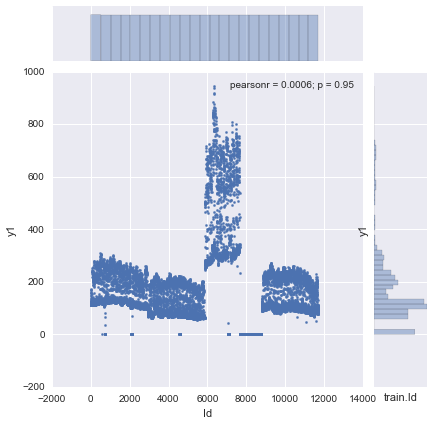

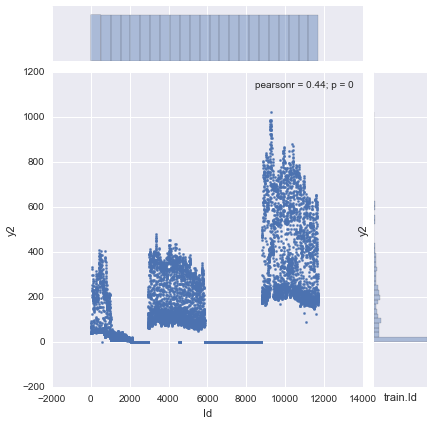

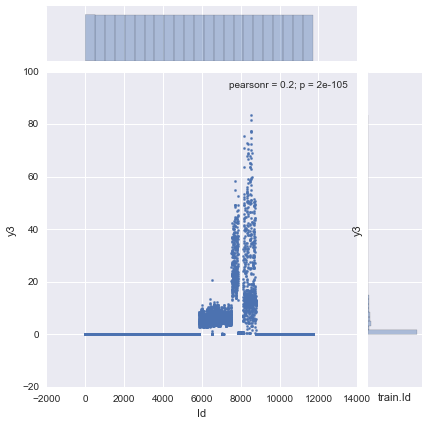

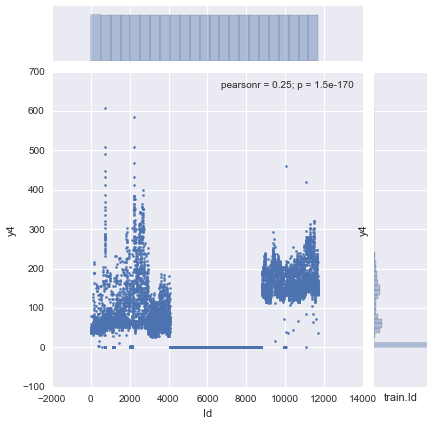

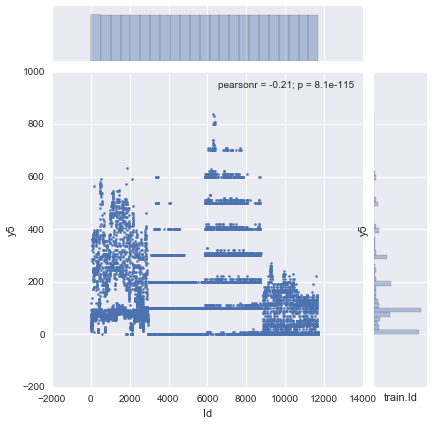

There is information in the Id field, which makes sense, since data is ordered by date


In [5]:
# Look for information in the id variable before dropping it
sns.jointplot(x = train.Id, y = y.y1, s = 5)
plt.xlabel("train.Id")
plt.ylabel("y1")
plt.show()
sns.jointplot(x = train.Id, y = y.y2, s = 5)
plt.xlabel("train.Id")
plt.ylabel("y2")
plt.show()
sns.jointplot(x = train.Id, y = y.y3, s = 5)
plt.xlabel("train.Id")
plt.ylabel("y3")
plt.show()
sns.jointplot(x = train.Id, y = y.y4, s = 5)
plt.xlabel("train.Id")
plt.ylabel("y4")
plt.show()
sns.jointplot(x = train.Id, y = y.y5, s = 5)
plt.xlabel("train.Id")
plt.ylabel("y5")
plt.show()

print("There is information in the Id field, which makes sense, since data is ordered by date")

Target variables are continuous -> regression problem


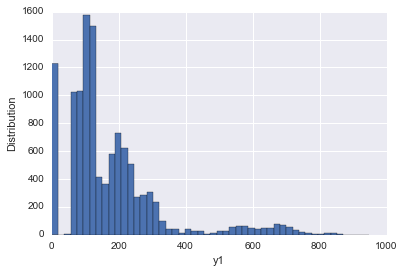

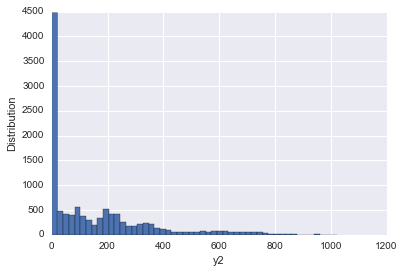

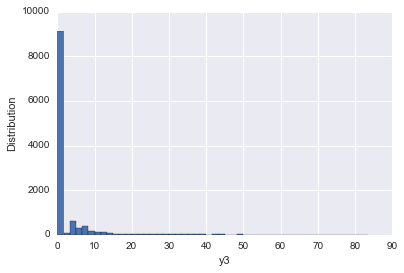

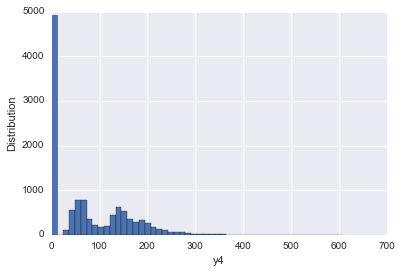

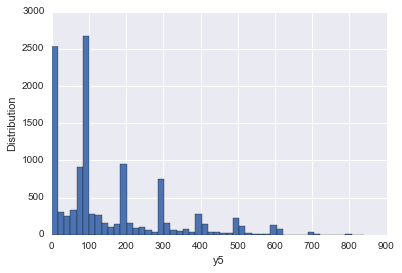

In [6]:
# Looking at the target variables distribution
print("Target variables are continuous -> regression problem")
plt.hist(y.y1, bins = 50)
plt.xlabel("y1")
plt.ylabel("Distribution")
plt.show()
plt.hist(y.y2, bins = 50)
plt.xlabel("y2")
plt.ylabel("Distribution")
plt.show()
plt.hist(y.y3, bins = 50)
plt.xlabel("y3")
plt.ylabel("Distribution")
plt.show()
plt.hist(y.y4, bins = 50)
plt.xlabel("y4")
plt.ylabel("Distribution")
plt.show()
plt.hist(y.y5, bins = 50)
plt.xlabel("y5")
plt.ylabel("Distribution")
plt.show()


In [7]:
print("Important remark: for some buildings, some consumptions are not used to heat/cool rooms. In this case, all data of \
the corresponding output are set to 0 (zero) and this output has to be ignored (you do not have to predict it). This \
is for instance the case for output y3 for building with Id_bat 1.")

Important remark: for some buildings, some consumptions are not used to heat/cool rooms. In this case, all data of the corresponding output are set to 0 (zero) and this output has to be ignored (you do not have to predict it). This is for instance the case for output y3 for building with Id_bat 1.


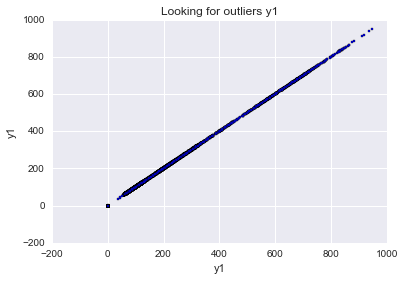

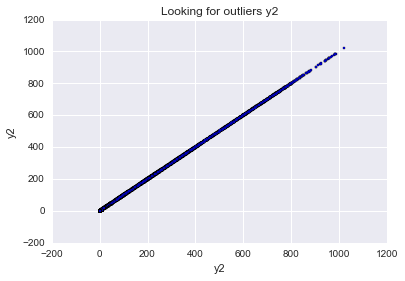

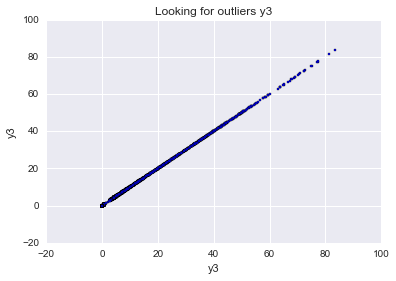

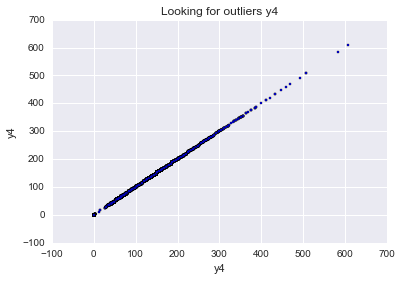

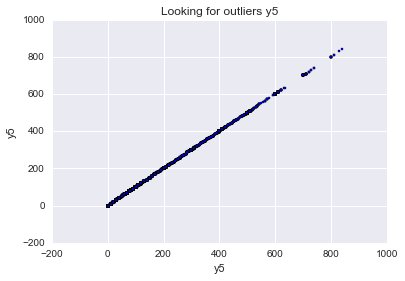

In [8]:
# Looking for outliers in the target variables 
plt.scatter(y.y1, y.y1, c = "blue", marker = "s", s = 5)
plt.title("Looking for outliers y1")
plt.xlabel("y1")
plt.ylabel("y1")
plt.show()
plt.scatter(y.y2, y.y2, c = "blue", marker = "s", s = 5)
plt.title("Looking for outliers y2")
plt.xlabel("y2")
plt.ylabel("y2")
plt.show()
plt.scatter(y.y3, y.y3, c = "blue", marker = "s", s = 5)
plt.title("Looking for outliers y3")
plt.xlabel("y3")
plt.ylabel("y3")
plt.show()
plt.scatter(y.y4, y.y4, c = "blue", marker = "s", s = 5)
plt.title("Looking for outliers y4")
plt.xlabel("y4")
plt.ylabel("y4")
plt.show()
plt.scatter(y.y5, y.y5, c = "blue", marker = "s", s = 5)
plt.title("Looking for outliers y5")
plt.xlabel("y5")
plt.ylabel("y5")
plt.show()

In [9]:
# Concatenate train and test for global preprocessing
alldata = pd.concat([train, test], axis = 0)

In [10]:
# Differentiate numerical features (minus the target) and categorical features
cat_features = alldata.select_dtypes(include = ["object"]).columns
print("Categorical features : " + str(len(cat_features)))
num_features = alldata.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(num_features)))

Categorical features : 1
Numerical features : 7


In [11]:
# Look at missing values
print("NAs : " + str(alldata.isnull().values.sum()))
print(alldata.isnull().sum())

print("Imputing NAs as zero for now")
alldata.loc[:, "x1"] = alldata.loc[:, "x1"].fillna(0)
alldata.loc[:, "x2"] = alldata.loc[:, "x2"].fillna(0)
alldata.loc[:, "x3"] = alldata.loc[:, "x3"].fillna(0)
alldata.loc[:, "x4"] = alldata.loc[:, "x4"].fillna(0)
alldata.loc[:, "x5"] = alldata.loc[:, "x5"].fillna(0)
print("After NA imputing, remaining NAs : " + str(alldata.isnull().values.sum()))
print(alldata.shape)

NAs : 745
Id          0
Id_bat      0
Time        0
x1         47
x2        149
x3         47
x4        321
x5        181
dtype: int64
Imputing NAs as zero for now
After NA imputing, remaining NAs : 0
(14137, 8)


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


IndexError: index 1 is out of bounds for axis 0 with size 1

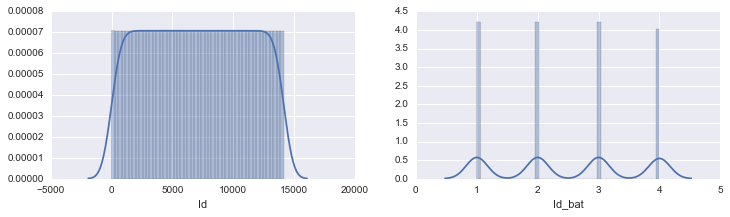

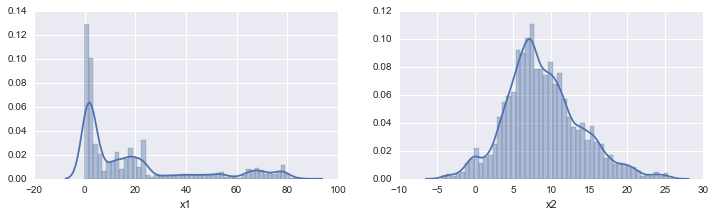

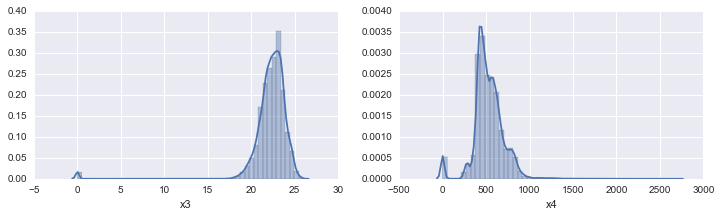

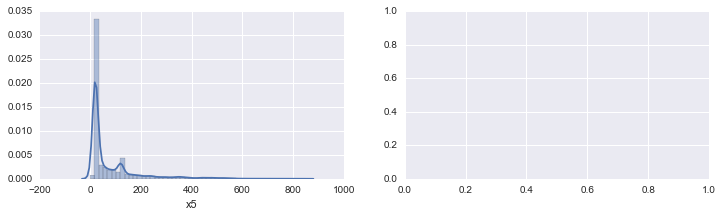

In [12]:
# Look at the distribution of all of the numerical features
ncol = 2
nrow = 4
for i in range(nrow):
    fig, axs = plt.subplots(nrows = 1, ncols = ncol, figsize = (12, 3))
    cols = num_features[(i * ncol): (ncol * (i + 1))]
    for j in range(len(axs)):
        sns.distplot(alldata[cols[j]], bins = 50, ax = axs[j])
        axs[j].set(xlabel = cols[j])

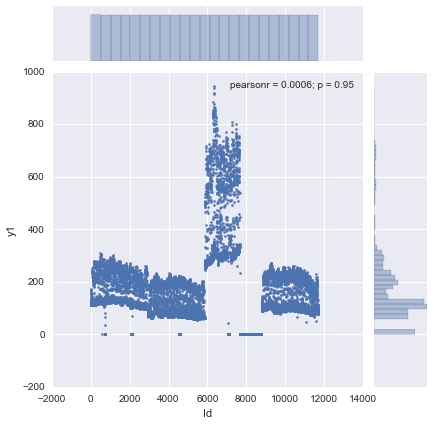

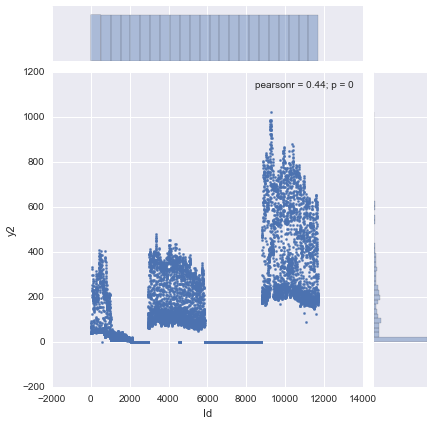

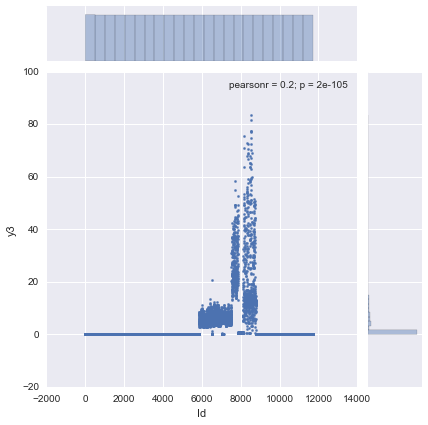

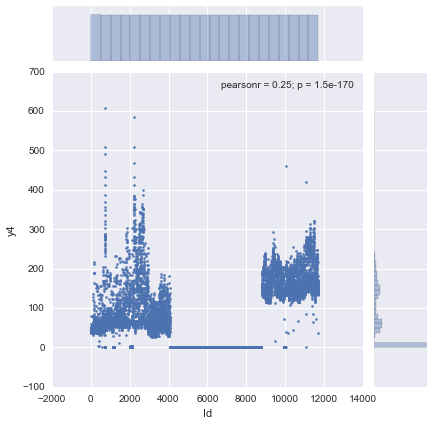

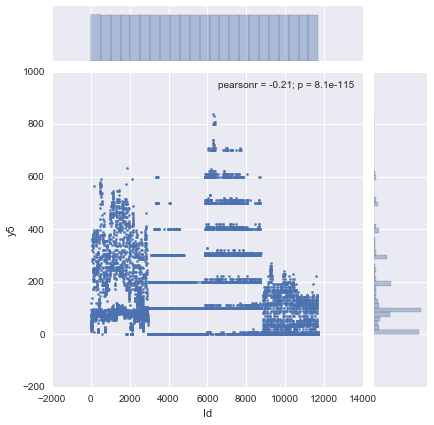

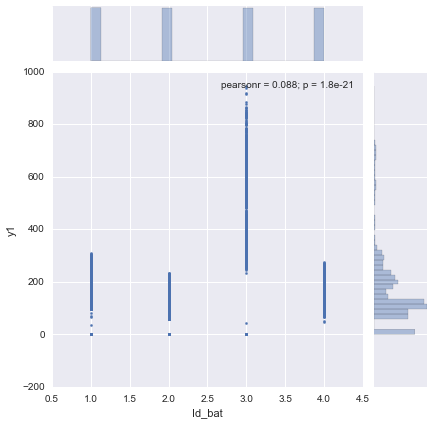

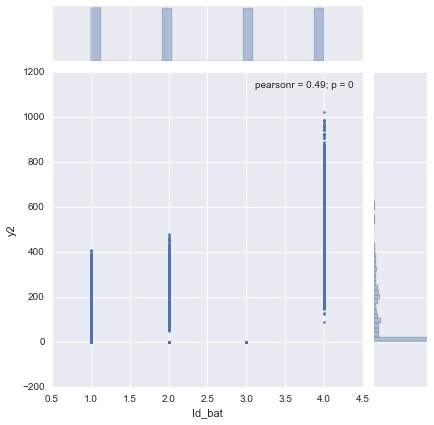

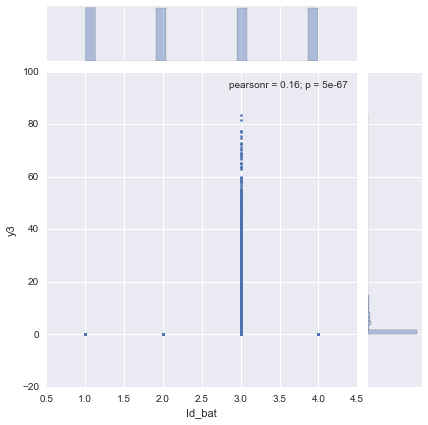

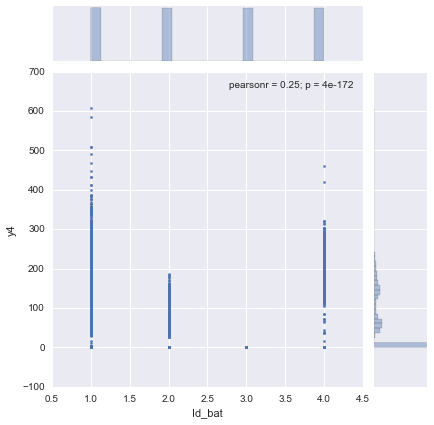

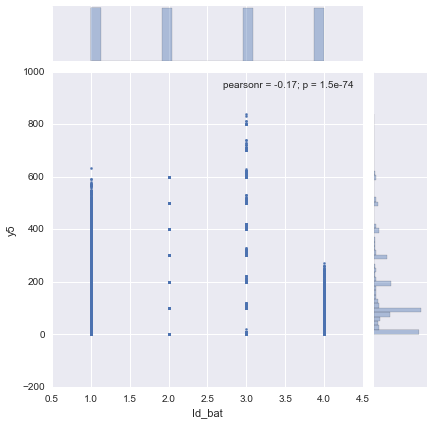

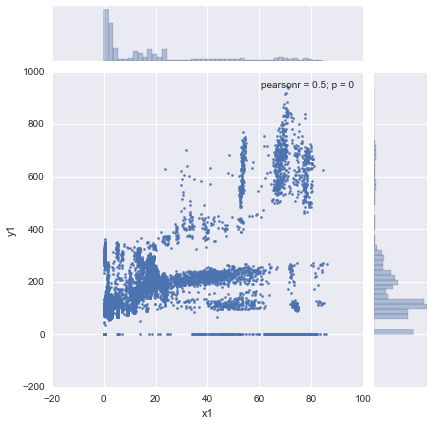

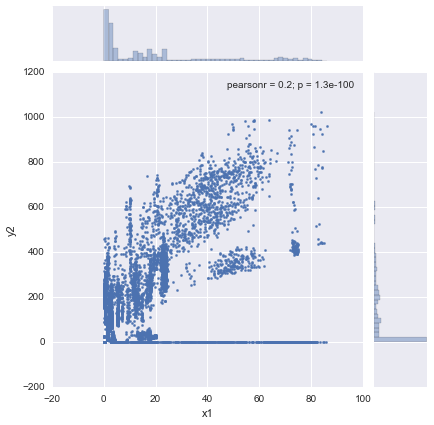

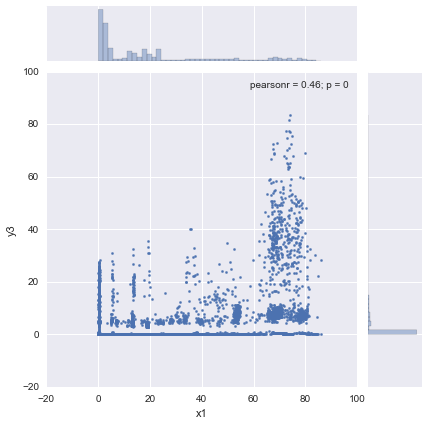

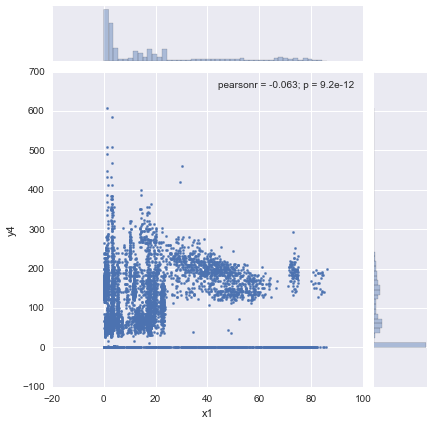

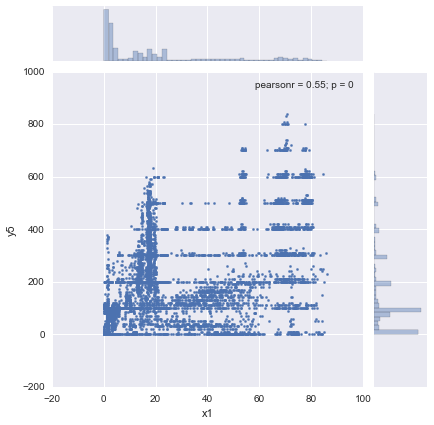

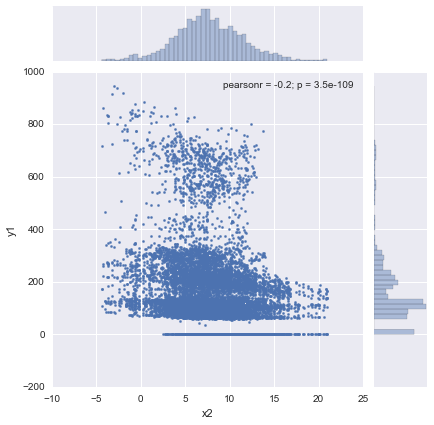

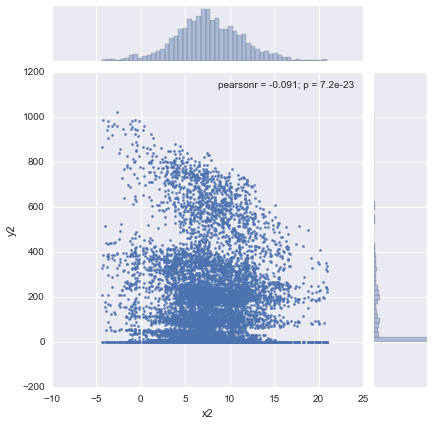

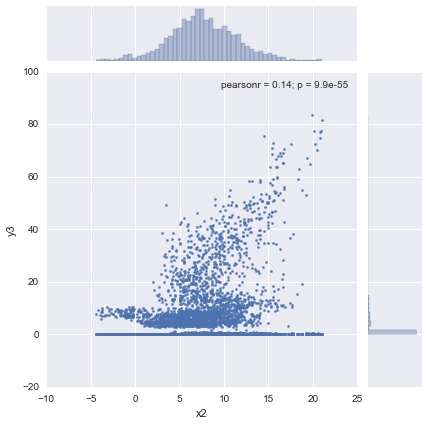

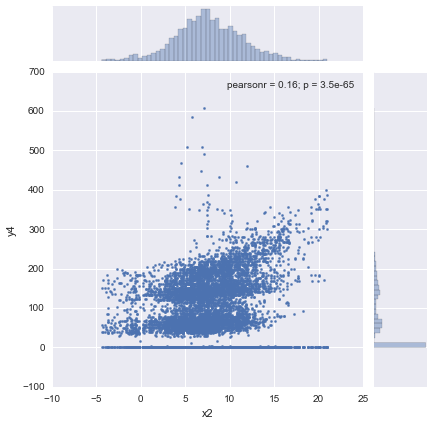

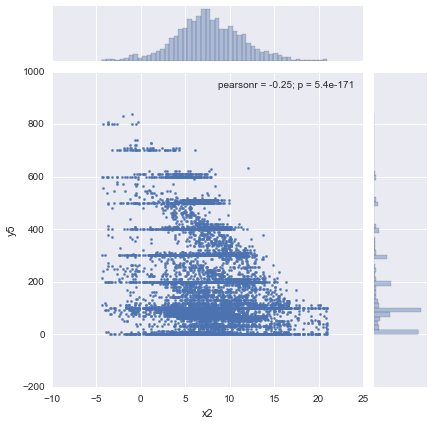

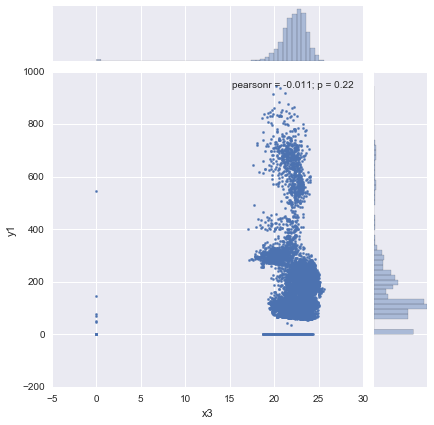

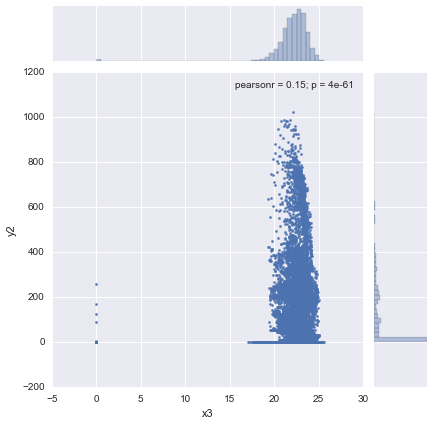

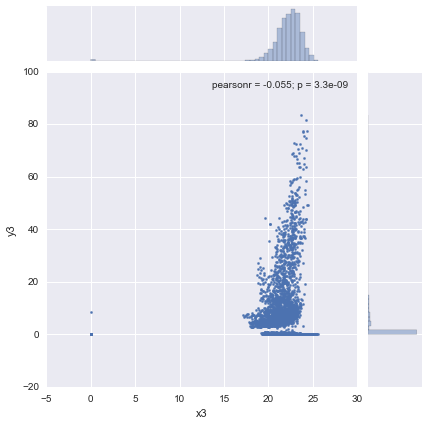

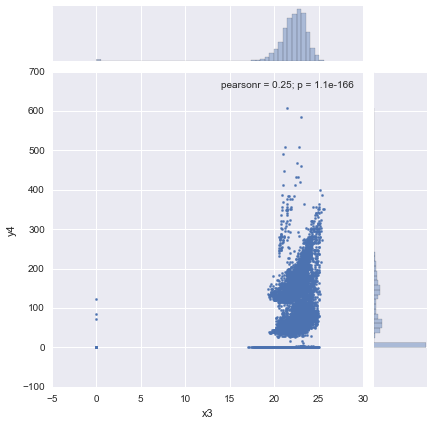

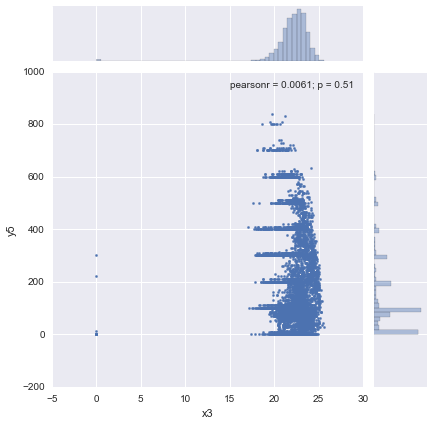

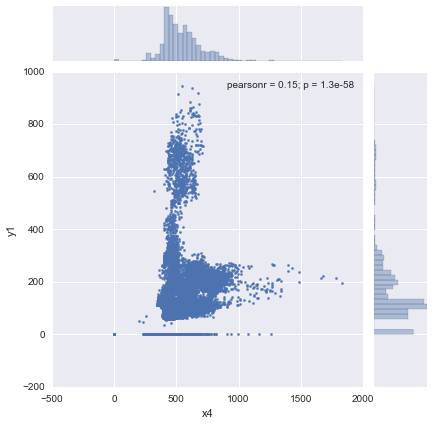

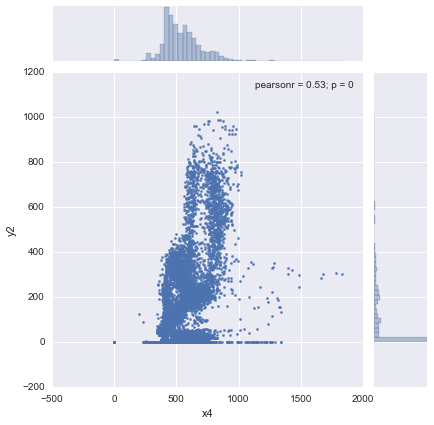

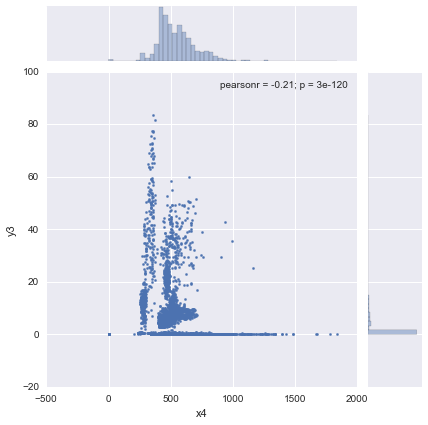

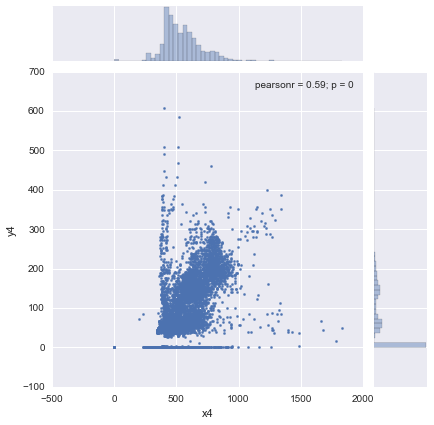

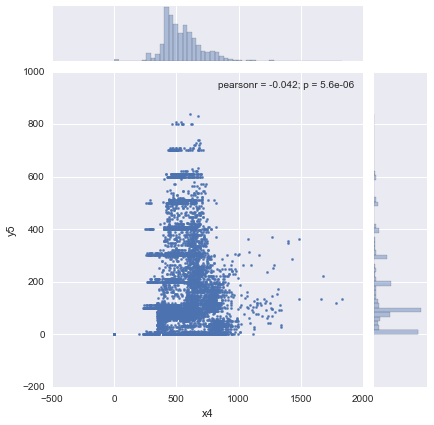

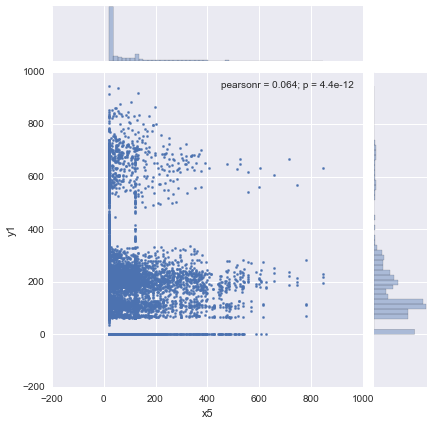

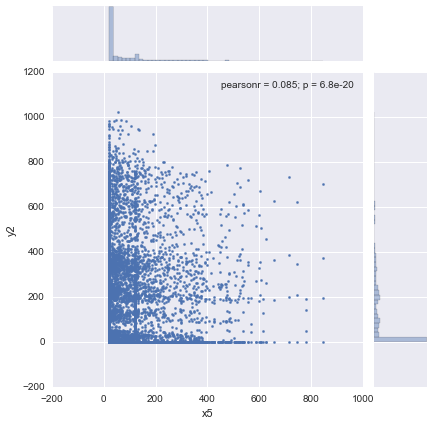

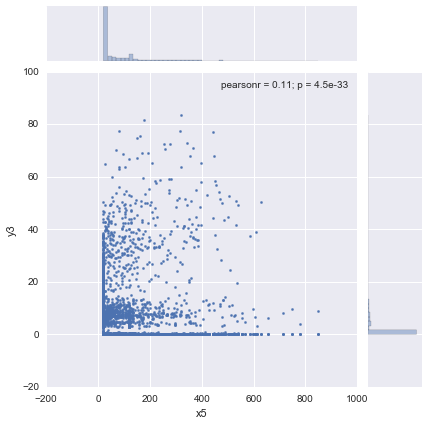

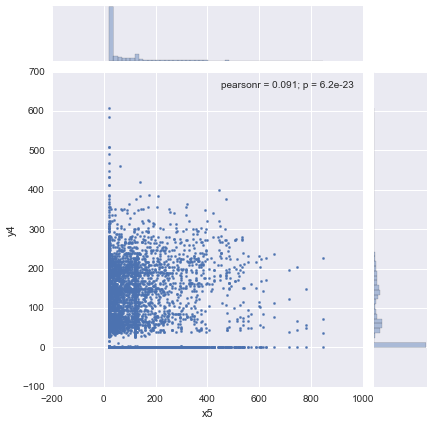

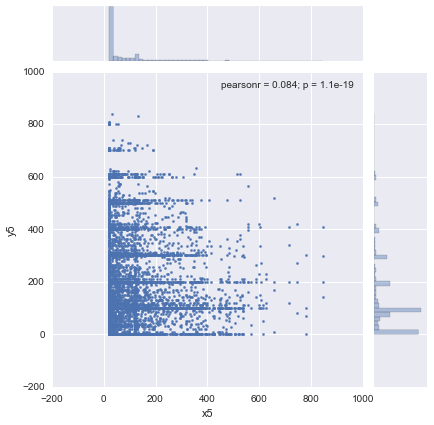

In [13]:
# Plot all the numerical features against the target
sns.jointplot(x = train["Id"], y = y.y1, s = 5)
plt.show()
sns.jointplot(x = train["Id"], y = y.y2, s = 5)
plt.show()
sns.jointplot(x = train["Id"], y = y.y3, s = 5)
plt.show()
sns.jointplot(x = train["Id"], y = y.y4, s = 5)
plt.show()
sns.jointplot(x = train["Id"], y = y.y5, s = 5)
plt.show()

sns.jointplot(x = train["Id_bat"], y = y.y1, s = 5)
plt.show()
sns.jointplot(x = train["Id_bat"], y = y.y2, s = 5)
plt.show()
sns.jointplot(x = train["Id_bat"], y = y.y3, s = 5)
plt.show()
sns.jointplot(x = train["Id_bat"], y = y.y4, s = 5)
plt.show()
sns.jointplot(x = train["Id_bat"], y = y.y5, s = 5)
plt.show()

sns.jointplot(x = train["x1"], y = y.y1, s = 5)
plt.show()
sns.jointplot(x = train["x1"], y = y.y2, s = 5)
plt.show()
sns.jointplot(x = train["x1"], y = y.y3, s = 5)
plt.show()
sns.jointplot(x = train["x1"], y = y.y4, s = 5)
plt.show()
sns.jointplot(x = train["x1"], y = y.y5, s = 5)
plt.show()

sns.jointplot(x = train["x2"], y = y.y1, s = 5)
plt.show()
sns.jointplot(x = train["x2"], y = y.y2, s = 5)
plt.show()
sns.jointplot(x = train["x2"], y = y.y3, s = 5)
plt.show()
sns.jointplot(x = train["x2"], y = y.y4, s = 5)
plt.show()
sns.jointplot(x = train["x2"], y = y.y5, s = 5)
plt.show()

sns.jointplot(x = train["x3"], y = y.y1, s = 5)
plt.show()
sns.jointplot(x = train["x3"], y = y.y2, s = 5)
plt.show()
sns.jointplot(x = train["x3"], y = y.y3, s = 5)
plt.show()
sns.jointplot(x = train["x3"], y = y.y4, s = 5)
plt.show()
sns.jointplot(x = train["x3"], y = y.y5, s = 5)
plt.show()

sns.jointplot(x = train["x4"], y = y.y1, s = 5)
plt.show()
sns.jointplot(x = train["x4"], y = y.y2, s = 5)
plt.show()
sns.jointplot(x = train["x4"], y = y.y3, s = 5)
plt.show()
sns.jointplot(x = train["x4"], y = y.y4, s = 5)
plt.show()
sns.jointplot(x = train["x4"], y = y.y5, s = 5)
plt.show()

sns.jointplot(x = train["x5"], y = y.y1, s = 5)
plt.show()
sns.jointplot(x = train["x5"], y = y.y2, s = 5)
plt.show()
sns.jointplot(x = train["x5"], y = y.y3, s = 5)
plt.show()
sns.jointplot(x = train["x5"], y = y.y4, s = 5)
plt.show()
sns.jointplot(x = train["x5"], y = y.y5, s = 5)
plt.show()


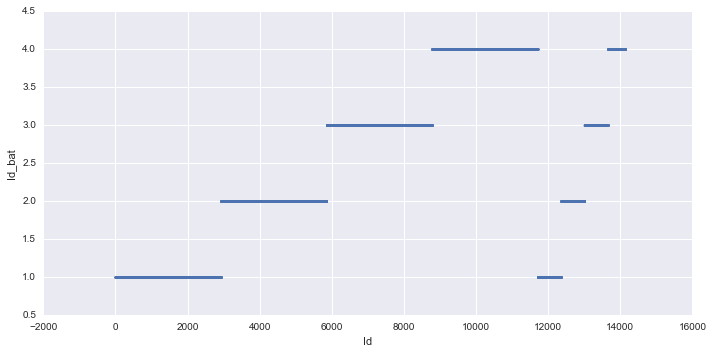

In [14]:
# Let's look at the Id field
sns.lmplot(x = "Id", 
           y = "Id_bat", 
           data = alldata, 
           fit_reg = False, 
           scatter_kws = {"s": 5}, 
           aspect = 2)
plt.show()

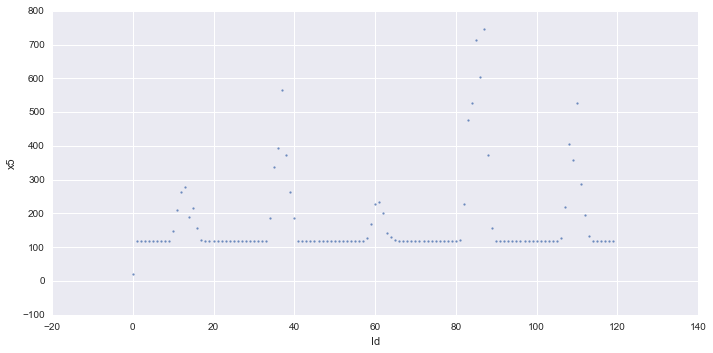

In [15]:
# Let's look at x2 vs Id
sns.lmplot(x = "Id", 
           y = "x5", 
           data = alldata[0:120], 
           fit_reg = False, 
           scatter_kws = {"s": 5}, 
           aspect = 2)
plt.show()

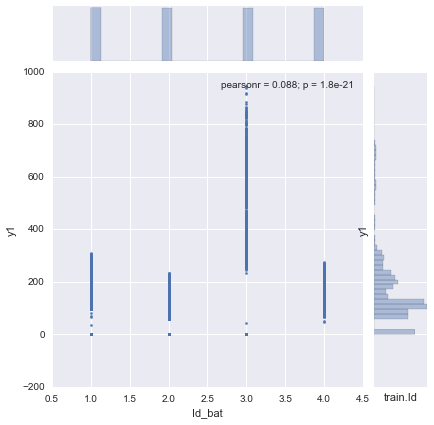

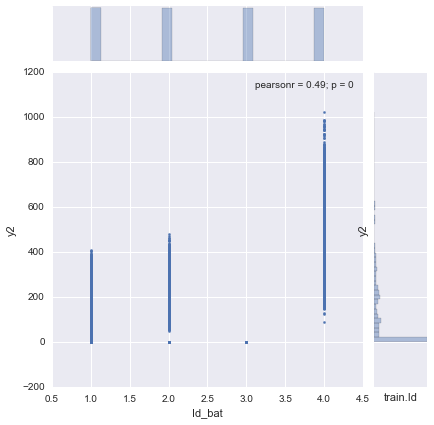

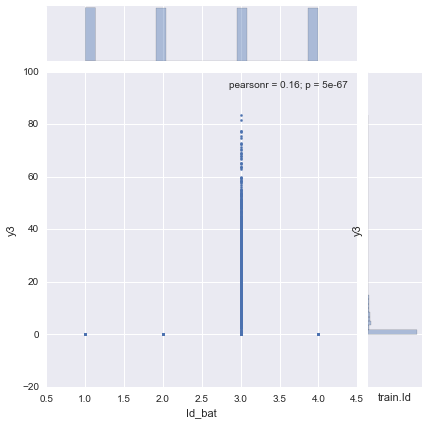

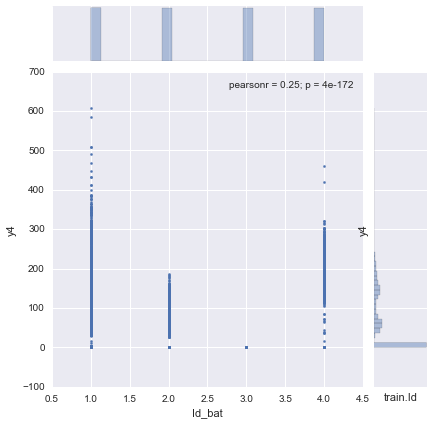

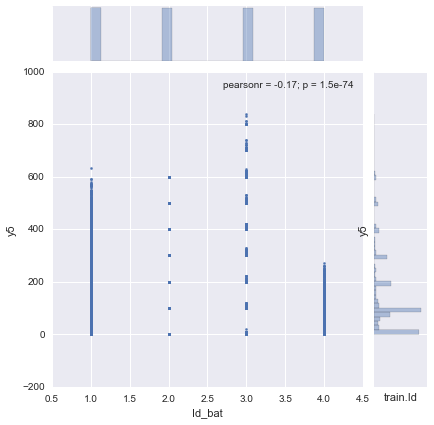

In [18]:
# Look for information in the id variable before dropping it
sns.jointplot(x = train.Id_bat, y = y.y1, s = 5)
plt.xlabel("train.Id")
plt.ylabel("y1")
plt.show()
sns.jointplot(x = train.Id_bat, y = y.y2, s = 5)
plt.xlabel("train.Id")
plt.ylabel("y2")
plt.show()
sns.jointplot(x = train.Id_bat, y = y.y3, s = 5)
plt.xlabel("train.Id")
plt.ylabel("y3")
plt.show()
sns.jointplot(x = train.Id_bat, y = y.y4, s = 5)
plt.xlabel("train.Id")
plt.ylabel("y4")
plt.show()
sns.jointplot(x = train.Id_bat, y = y.y5, s = 5)
plt.xlabel("train.Id")
plt.ylabel("y5")
plt.show()

In [21]:
print("-----\n" + str(y.loc[train.Id_bat == 3, "y5"].value_counts()) + "\n-----")


-----
100.000    661
300.000    436
0.000      334
200.000    317
400.000    176
500.000    152
600.000    117
310.000    109
410.000    106
510.000    100
110.000     93
210.000     79
610.000     74
700.000     41
10.000      37
420.000     17
710.000     14
320.000     12
620.000      9
800.000      8
220.000      6
520.000      6
120.000      5
720.000      3
530.000      3
810.000      2
730.000      2
740.000      2
330.000      2
830.000      1
20.000       1
630.000      1
840.000      1
Name: y5, dtype: int64
-----


In [ ]:
'''# Some numerical features are actually really categories
alldata = alldata.replace({"Id_bat" : {1 : "B1", 2 : "B2", 3 : "B3", 4 : "B4"}})

cat_features = alldata.select_dtypes(include = ["object"]).columns
num_features = alldata.select_dtypes(exclude = ["object"]).columns'''